#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2024

You are required to submit your mini-projects by midnight on 07/05/24. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

<!-- You have until midnight of 07/05/23 to submit your mini-projects. You will be requested to upload a .zip file on Moodle containing your code and, specifically, the following:

- A one-page report (Report.pdf) detailing your investigation:
    - A table with model comparison: linear regression from stimuli, task-driven models (trained and random), data-driven models and your best model
    - A figure showing how the neural prediction changes across layer of a task-driven model
- A script (test.py) or notebook (test.ipynb) in which you show an example of your best model's usage on the validation set. -->

In [1]:
import sys
!{sys.executable} -m pip install gdown h5py

In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=451f268b-3e5b-4a33-a77d-a5825868579a
To: /home/jupyter/Brain_like_mini_project/IT_data.h5
100%|██████████| 384M/384M [00:03<00:00, 102MB/s]  


'IT_data.h5'

### Load the data

In [3]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [4]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channels (RGB)
The size of the image is 224x224


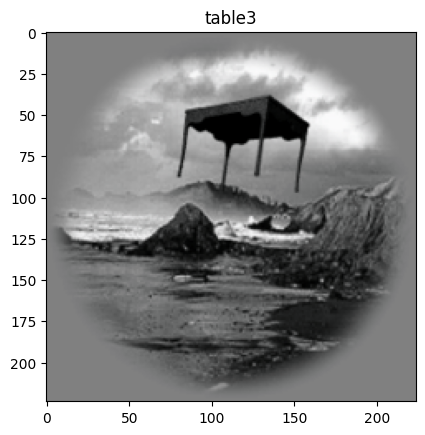

In [5]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

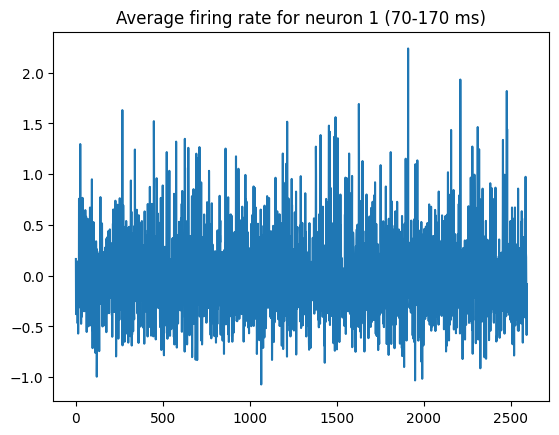

In [6]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

In [7]:
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.metrics import explained_variance_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [8]:
#data
X = stimulus_train.reshape(stimulus_train.shape[0], stimulus_train.shape[1]*stimulus_train.shape[2]*stimulus_train.shape[3])
y = spikes_train

In [9]:
#ridge regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X, y)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=5.02974e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Ridge()

##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

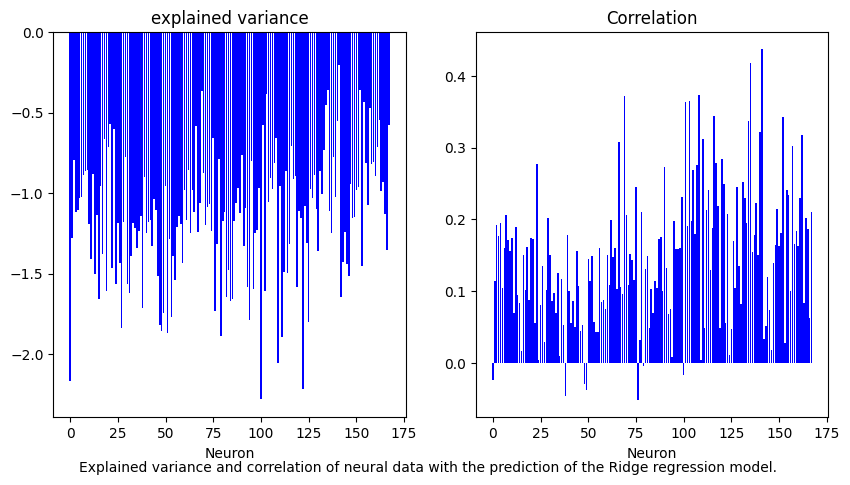

In [10]:
y_pred = ridge_model.predict(stimulus_val.reshape(stimulus_val.shape[0], stimulus_val.shape[1]*stimulus_val.shape[2]*stimulus_val.shape[3]))

correlation_scores = []
explained_variance_scores = []

for i in range(y.shape[1]):
    # Calculate correlation
    corr = np.corrcoef(spikes_val[:, i], y_pred[:, i])[0, 1]
    correlation_scores.append(corr)

    # Calculate explained variance
    explained_variance = explained_variance_score(spikes_val[:, i], y_pred[:, i])
    explained_variance_scores.append(explained_variance)

fig, axs = plt.subplots(1, 2, figsize = (10, 5))

axs[0].bar(range(y.shape[1]), explained_variance_scores, color='blue')
axs[0].set_xlabel('Neuron')
axs[0].set_title('explained variance')

axs[1].bar(range(y.shape[1]), correlation_scores, color='blue')
axs[1].set_xlabel('Neuron')
axs[1].set_title('Correlation')

txt = 'Explained variance and correlation of neural data with the prediction of the Ridge regression model.'
fig.text(.5, .0, txt, ha='center')


fig.savefig('Fig/ridge_model')

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity.

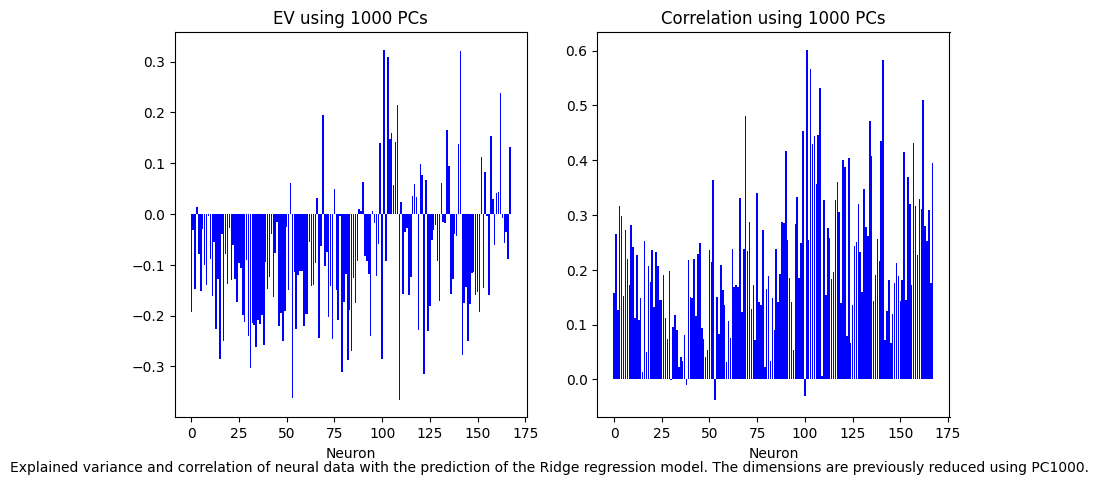

In [11]:
# Project the stimulus on its first 1000 PCs
pca = PCA(n_components=1000)
X_train_reduced = pca.fit_transform(stimulus_train.reshape(stimulus_train.shape[0], stimulus_train.shape[1]*stimulus_train.shape[2]*stimulus_train.shape[3]))
X_val_reduced = pca.transform(stimulus_val.reshape(stimulus_val.shape[0], stimulus_val.shape[1]*stimulus_val.shape[2]*stimulus_val.shape[3]))
y_train = spikes_train

# Re-train with lower-dimensional data
ridge_model_reduced = Ridge(alpha=1.0)
ridge_model_reduced.fit(X_train_reduced, y_train)

# Do the same analysis as above but with ridhe_model_reduced
y_pred_reduced = ridge_model_reduced.predict(X_val_reduced)
y_val = spikes_val

correlation_scores_reduced = []
explained_variance_scores_reduced = []

for i in range(y_val.shape[1]):
    # Correlation
    corr = np.corrcoef(y_val[:, i], y_pred_reduced[:, i])[0, 1]
    correlation_scores_reduced.append(corr)

    # Explained variance
    explained_variance = explained_variance_score(y_val[:, i], y_pred_reduced[:, i])
    explained_variance_scores_reduced.append(explained_variance)

fig, axs = plt.subplots(1, 2, figsize = (10, 5))

axs[0].bar(range(y_val.shape[1]), explained_variance_scores_reduced, color='blue')
axs[0].set_xlabel('Neuron')
axs[0].set_title('EV using 1000 PCs')

axs[1].bar(range(y_val.shape[1]), correlation_scores_reduced, color='blue')
axs[1].set_xlabel('Neuron')
axs[1].set_title('Correlation using 1000 PCs')

txt = 'Explained variance and correlation of neural data with the prediction of the Ridge regression model. The dimensions are previously reduced using PC1000.'
fig.text(.5, 0, txt, ha='center')


fig.savefig('Fig/ridge_model_reduced')

##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [12]:
alphas = np.logspace(start=-4, stop=1, num=25)

# Use StratifiedKFold to preserve the percentage of samples for each class
skf = StratifiedKFold()
ev_alphas = []

for i in range(len(alphas)):

    ev_alpha = []
    rr_alpha = Ridge(alpha=alphas[i])

    for train_index, val_index in skf.split(X_train_reduced, np.array(objects_train)):
        x_train_fold, x_val_fold = X_train_reduced[train_index], X_train_reduced[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Fit the model using train data
        rr_alpha.fit(x_train_fold, y_train_fold)

        # Evaluate the model using validation data
        y_pred = rr_alpha.predict(x_train_fold)

        ev_tot = []
        for i in range(y_train_fold.shape[1]):
            ev_neuron = explained_variance_score(y_train_fold[:, i], y_pred[:, i])
            ev_tot.append(ev_neuron)

        ev_alpha.append(np.mean(ev_tot))

    ev_alphas.append(np.mean(ev_alpha))

In [13]:
best_alpha=alphas[np.argmax(ev_alphas)]

The model variance is GREATER than the true variance..., but the Pythagorean theorem states that $$\sum_{i=1}^{n}(y_i - \bar{y})^2 = \sum_{i=1}^{n}(\hat{y}_i - \bar{y})^2 + \sum_{i=1}^{n}(y_i - \hat{y}_i)^2.
$$


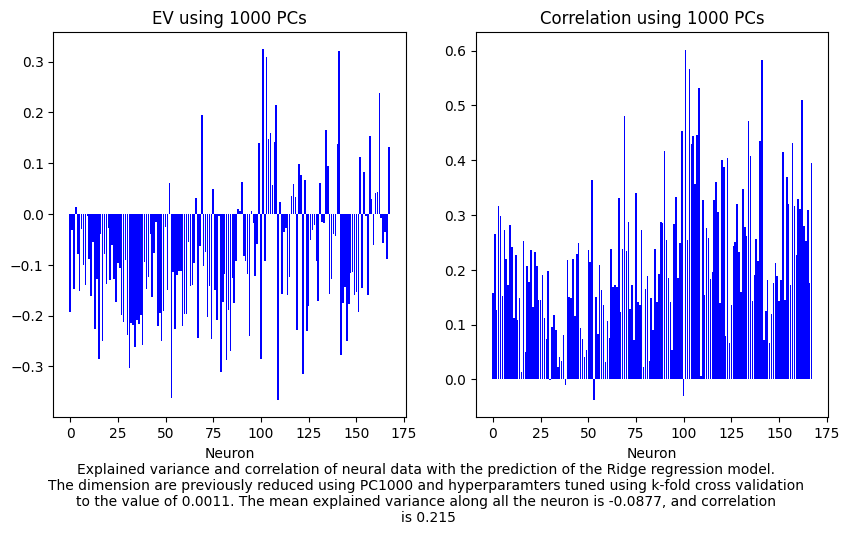

In [14]:
# Train again with the right hyperpaameters
Best_Ridge = Ridge(alpha=best_alpha)
Best_Ridge.fit(X_train_reduced, y_train)

# Do the same analysis as above but with ridhe_model_reduced
y_pred_reduced = Best_Ridge.predict(X_val_reduced)

correlation_scores_best = []
explained_variance_scores_best = []

for i in range(y_val.shape[1]):
    # Correlation
    corr = np.corrcoef(y_val[:, i], y_pred_reduced[:, i])[0, 1]
    correlation_scores_best.append(corr)

    # Explained variance
    explained_variance = explained_variance_score(y_val[:, i], y_pred_reduced[:, i])
    explained_variance_scores_best.append(explained_variance)

ev_mean = np.mean(explained_variance_scores_best)
corr_mean = np.mean(correlation_scores_best)

fig, axs = plt.subplots(1, 2, figsize = (10, 5))

axs[0].bar(range(y_val.shape[1]), explained_variance_scores_best, color='blue')
axs[0].set_xlabel('Neuron')
axs[0].set_title('EV using 1000 PCs')

axs[1].bar(range(y_val.shape[1]), correlation_scores_best, color='blue')
axs[1].set_xlabel('Neuron')
axs[1].set_title('Correlation using 1000 PCs')

txt = f'''Explained variance and correlation of neural data with the prediction of the Ridge regression model. 
The dimension are previously reduced using PC1000 and hyperparamters tuned using k-fold cross validation 
to the value of {best_alpha:.3}. The mean explained variance along all the neuron is {ev_mean:.3}, and correlation 
is {corr_mean:.3}'''

fig.text(.5, -0.1, txt, ha='center')

fig.savefig('Fig/best_ridge')

## Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [15]:
!pip install torchvision

In [35]:
import torch
import torchvision.models as models
from sklearn.decomposition import PCA

In [17]:
from functions import Dataset, DataLoader, save_activations, load_activations

In [18]:
# 1. run with pre trained model 
resnet50_model = models.resnet50(pretrained=True)
model_name = 'pretrained'
rnd = False

resnet50_model.eval() 

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Create DataLoader and DataSet to have batches

In [19]:
# Initialize the dataset and loader

training_data = Dataset(stimulus_train, objects_train) 
val_data = Dataset(stimulus_val, objects_val) 

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size = 64, shuffle = True)

## Extract the activations for train and val data

In [38]:
# To Store each activation in a dictionary : 
ACTIVATIONS  = {}
ACTIVATIONS_VAL = {}

PCA_to_save= {}

In [39]:
# hook function
def hook(model, input, output, ):
    activations.append(output.detach().reshape(output.shape[0], -1))

In [40]:
# Set the PCA funciton 
pca = PCA(n_components=1000)

### conv1

**Train dataloader**

In [17]:
# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.conv1.register_forward_hook(hook)

for batch_x, batch_y in train_dataloader:
    resnet50_model(batch_x)

act_reduced = pca.fit_transform(activations)

# Remove the hook at the end of the forward
hook_handle.remove()

In [17]:
# Save the pca
PCA_to_save['conv1'] = pca

In [18]:
# Storage
ACTIVATIONS['conv1'] = act_reduced

**Val dataloader**

In [19]:
# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.conv1.register_forward_hook(hook)

for batch_x, batch_y in val_dataloader:
    resnet50_model(batch_x)

act_reduced = PCA_to_save['conv1'].transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

In [20]:
# Storage
ACTIVATIONS_VAL['conv1'] = act_reduced

### layer1

**Train dataloader**

In [76]:
# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.layer1.register_forward_hook(hook)

for batch_x, batch_y in train_dataloader:
    resnet50_model(batch_x)
    
act_reduced = pca.fit_transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

1


In [25]:
# Save the pca
PCA_to_save['layer1'] = pca

In [26]:
# Storage
ACTIVATIONS['layer1'] = act_reduced

**Val Dataloader**

In [27]:
# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.layer1.register_forward_hook(hook)

for batch_x, batch_y in val_dataloader:
    resnet50_model(batch_x)
    
act_reduced = PCA_to_save['layer1'].transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

In [28]:
# Storage
ACTIVATIONS_VAL['layer1'] = act_reduced

### layer2

**Train dataloader**

In [17]:
# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.layer2.register_forward_hook(hook)

for batch_x, batch_y in train_dataloader:
    resnet50_model(batch_x)
    
act_reduced = pca.fit_transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

In [18]:
# Save the pca
PCA_to_save['layer2'] = pca

In [19]:
# Storage
ACTIVATIONS['layer2'] = act_reduced

**Val Dataloader**

In [20]:
# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.layer2.register_forward_hook(hook)

for batch_x, batch_y in val_dataloader:
    resnet50_model(batch_x)
    
act_reduced = PCA_to_save['layer2'].transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

In [21]:
# Storage
ACTIVATIONS_VAL['layer2'] = act_reduced

### layer3

**Train dataloader**

In [19]:
# Interate throught the batches and store the activations
activations= []
hook_handle = resnet50_model.layer3.register_forward_hook(hook)

for batch_x, batch_y in train_dataloader:
    resnet50_model(batch_x)
    
act_reduced = pca.fit_transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

In [ ]:
# Save the pca
PCA_to_save['layer3'] = pca

In [21]:
# Storage
ACTIVATIONS['layer3'] = act_reduced

**Val dataloader**

In [22]:
# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.layer3.register_forward_hook(hook)

for batch_x, batch_y in val_dataloader:
    resnet50_model(batch_x)
    
act_reduced = PCA_to_save['layer3'].transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

In [23]:
# Storage
ACTIVATIONS_VAL['layer3'] = act_reduced

### layer4

**Train Dataloader**

In [22]:
# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.layer4.register_forward_hook(hook)

for batch_x, batch_y in train_dataloader:
    resnet50_model(batch_x)
    
act_reduced = pca.fit_transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

In [23]:
# Save the pca
PCA_to_save['layer4'] = pca

In [24]:
# Storage
ACTIVATIONS['layer4'] = act_reduced

**Val Dataloader**

In [25]:
# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.layer4.register_forward_hook(hook)

for batch_x, batch_y in val_dataloader:
    resnet50_model(batch_x)
    
act_reduced = PCA_to_save['layer4'].transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

In [26]:
# Storage
ACTIVATIONS_VAL['layer4'] = act_reduced

### avgpool

**Train dataloader**

In [26]:
# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.avgpool.register_forward_hook(hook)

for batch_x, batch_y in train_dataloader:
    resnet50_model(batch_x)
    
act_reduced = pca.fit_transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

In [27]:
# Save the pca
PCA_to_save['avgpool'] = pca

In [28]:
# Storage
ACTIVATIONS['avgpool'] = act_reduced

**Val dataloader**

In [29]:
# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.avgpool.register_forward_hook(hook)

for batch_x, batch_y in val_dataloader:
    resnet50_model(batch_x)

act_reduced = PCA_to_save['avgpool'].transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

In [30]:
# Storage
ACTIVATIONS_VAL['avgpool'] = act_reduced

### Saving into csv files

In [24]:
save_activations(ACTIVATIONS,'train', rnd = rnd)
save_activations(ACTIVATIONS_VAL,'val', rnd = rnd)

saving complete in Activations_RND/train_layer2.csv
saving complete in Activations_RND/test_layer2.csv
saving complete in Activations_RND/val_layer2.csv


## Load the csv fils

In [20]:
ACTIVATIONS = load_activations('train', rnd = rnd)
ACTIVATIONS_VAL = load_activations('val', rnd = rnd)

## Ridge regression for each layer

#### Cross validation

In [21]:
alphas = np.logspace(start=-8, stop=0, num=25)

skf = StratifiedKFold()

best_alphas = {}

for layer_name, act in ACTIVATIONS.items() :
    ev_alphas = []
    for i in range(len(alphas)):
    
        ev_alpha = []
        rr_alpha = Ridge(alpha=alphas[i])

        for train_index, val_index in skf.split(act, np.array(objects_train)):
            x_train_fold, x_val_fold = act[train_index], act[val_index]
            y_train_fold, y_val_fold = spikes_train[train_index], spikes_train[val_index]

            # Fit the model using train data
            rr_alpha.fit(x_train_fold, y_train_fold)

            # Evaluate the model using validation data
            y_pred = rr_alpha.predict(x_val_fold)

            ev_tot = []
            
            for i in range(y_val_fold.shape[1]):
                ev_neuron = explained_variance_score(y_val_fold[:, i], y_pred[:, i])
                ev_tot.append(ev_neuron)

            ev_alpha.append(np.mean(ev_tot))

        ev_alphas.append(np.mean(ev_alpha))
    
    # Select the best alpha for this layer    
    best_alpha=alphas[np.argmax(ev_alphas)]
    
    best_alphas[layer_name] = best_alpha
    

In [22]:
for layer, alpha in best_alphas.items():
    print(f'For layer {layer} the best hyperparamters is {alpha}.')

For layer conv1 the best hyperparamters is 1.0.
For layer layer1 the best hyperparamters is 1.0.
For layer layer2 the best hyperparamters is 1.0.
For layer layer3 the best hyperparamters is 1.0.
For layer layer4 the best hyperparamters is 1.0.
For layer avgpool the best hyperparamters is 1.0.


#### Ridge regression on activation

In [23]:
# Use the PCs of each layer to predict the neural activity using the linear regression model developed before.
out = {}
models_dict = {}

for layer_name, act in ACTIVATIONS.items():
    ridge_model=  Ridge(alpha=best_alphas[layer_name])
    ridge_model.fit(act, np.array(spikes_train))

for layer_name, act in ACTIVATIONS_VAL.items():
    models_dict[layer_name] = ridge_model
    out[layer_name] = models_dict[layer_name].predict(act) 

In [24]:
correlation = {}
explained_variance = {}

In [25]:
# Compute the goodness of fit using the correlation and explained variance metrics.
for layer_name, y_pred in out.items():
    correlation_scores = [] 
    explained_variance_scores = [] 
    
    for i in range(y_pred.shape[1]):
        # Correlation
        corr = np.corrcoef(spikes_val[:, i], y_pred[:, i])[0, 1]
        correlation_scores.append(corr)

        # Explained variance
        ev = explained_variance_score(spikes_val[:, i], y_pred[:, i])
        explained_variance_scores.append(ev)

    correlation[layer_name] = correlation_scores
    explained_variance[layer_name] = explained_variance_scores

Q: Do we predict the neural activity better than before?

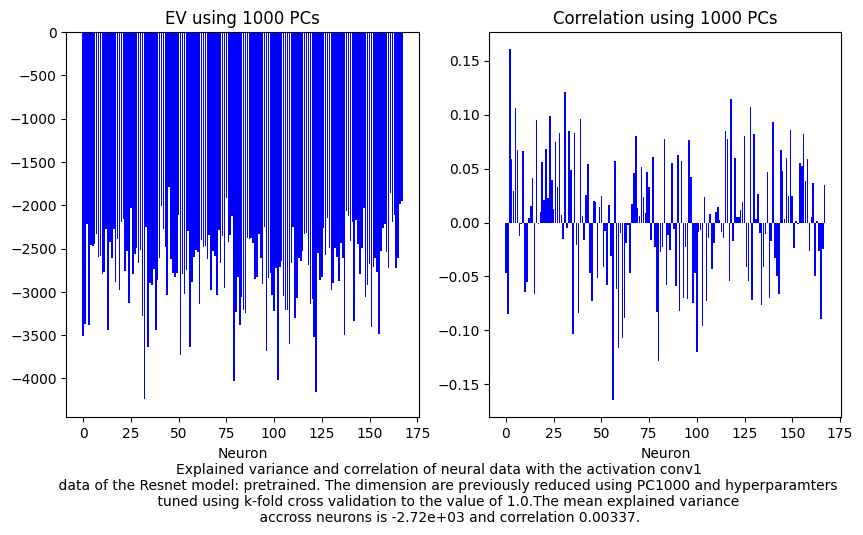

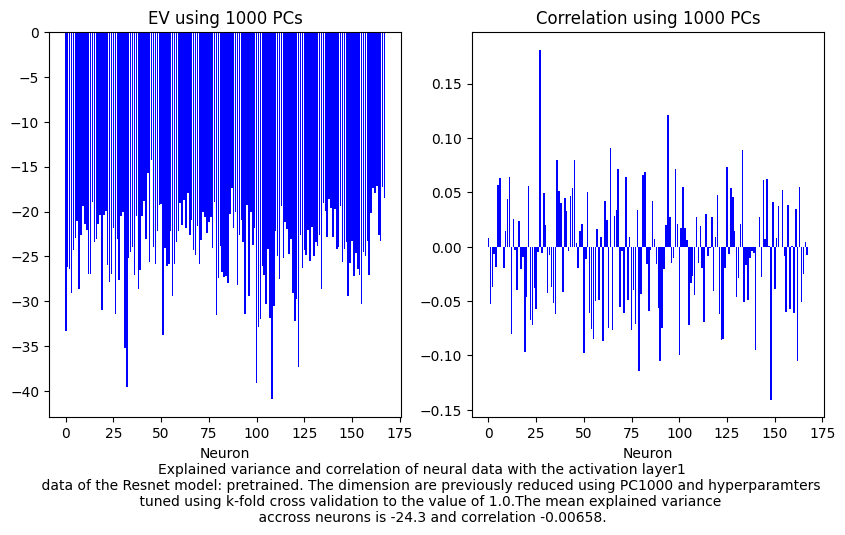

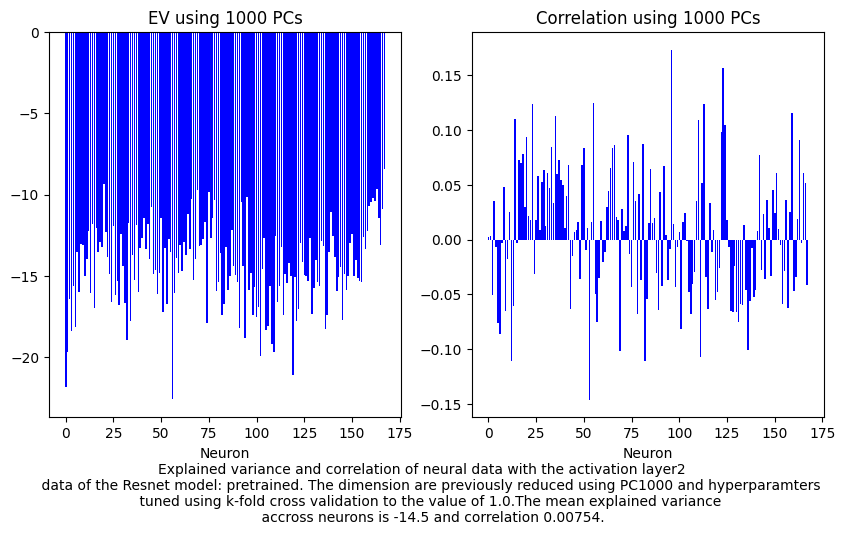

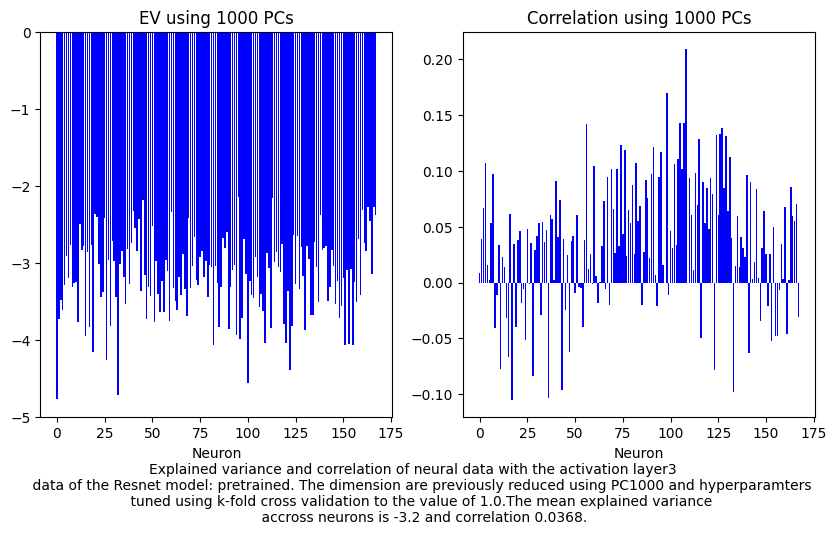

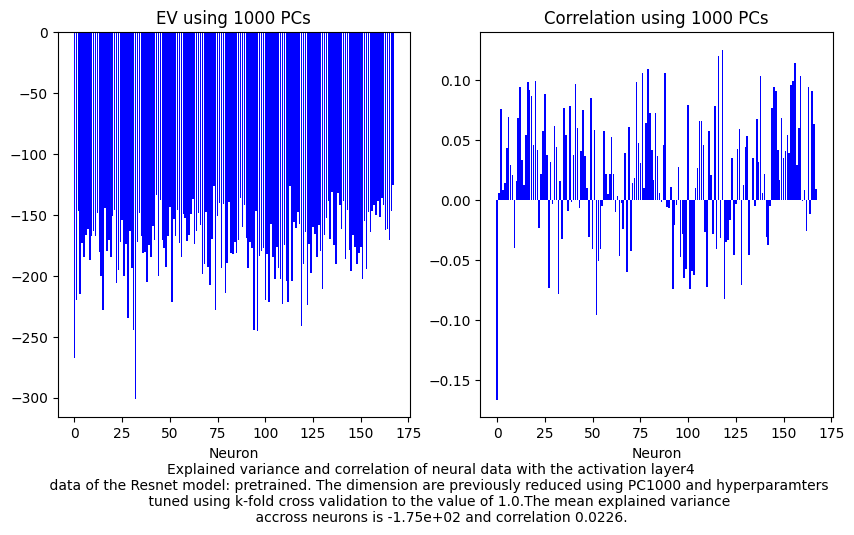

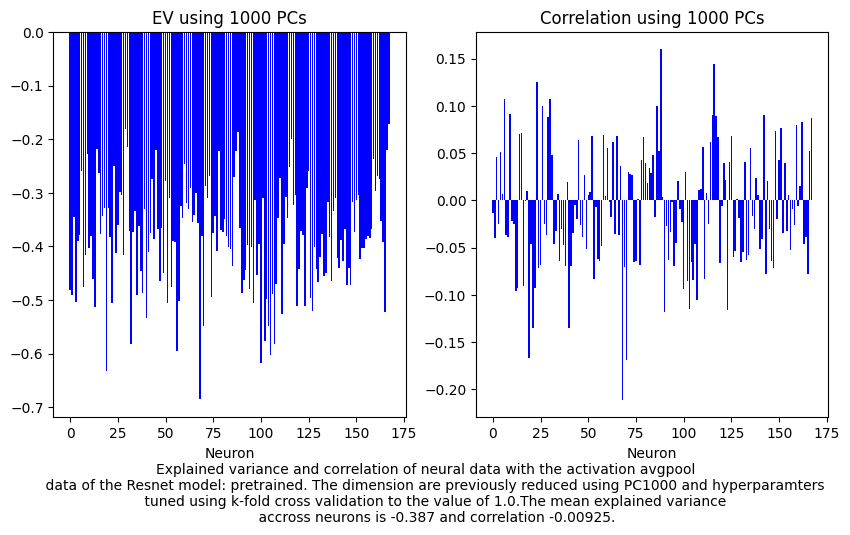

In [31]:
# Plot the distribution of explained variance with respect to the layer of the network, order them based on the depth.

for layer_name in explained_variance.keys() :
    fig, axs = plt.subplots(1, 2, figsize = (10, 5))

    axs[0].bar(range(spikes_val.shape[1]), explained_variance[layer_name], color='blue')
    axs[0].set_xlabel('Neuron')
    axs[0].set_title('EV using 1000 PCs')

    axs[1].bar(range(spikes_val.shape[1]), correlation[layer_name], color='blue')
    axs[1].set_xlabel('Neuron')
    axs[1].set_title('Correlation using 1000 PCs')
    
    path_to_save = f'Fig/ev_{model_name}_{layer_name}'
    mean_ev = np.mean(explained_variance[layer_name])
    mean_corr = np.mean(correlation[layer_name])
    
    txt = f'''Explained variance and correlation of neural data with the activation {layer_name} 
    data of the Resnet model: {model_name}. The dimension are previously reduced using PC1000 and hyperparamters 
    tuned using k-fold cross validation to the value of {best_alphas[layer_name]:.3}.The mean explained variance 
    accross neurons is {mean_ev:.3} and correlation {mean_corr:.3}.'''
    
    fig.text(.5, -0.1, txt, ha='center')

    
    fig.savefig(path_to_save)

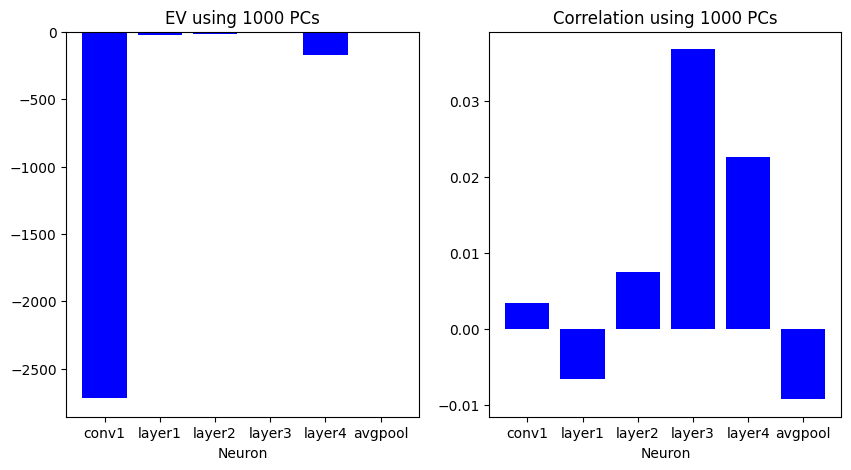

In [32]:
evs = [np.mean(ev) for layer_name, ev in explained_variance.items()]  
correl = [np.mean(corr) for layer_name, corr in correlation.items()]  

fig, axs = plt.subplots(1, 2, figsize = (10, 5))

axs[0].bar(explained_variance.keys(), evs, color='blue')
axs[0].set_xlabel('Neuron')
axs[0].set_title('EV using 1000 PCs')

axs[1].bar(correlation.keys(), correl, color='blue')
axs[1].set_xlabel('Neuron')
axs[1].set_title('Correlation using 1000 PCs')

fig.savefig(f'Fig/ev_{model_name}')

Q: How does the neural activity changes across the model layers, can you make some statements about it?


# rdn 

The best predictions comes from the layer 3.

In [46]:
# With randomly initilized model
resnet50_model_rnd = models.resnet50(weights=None)
model_name = 'rnd'
rnd = True
layer_name = 'layer3'

In [47]:
# Interate throught the batches and store the activations
activations= []
hook_handle = resnet50_model_rnd.layer3.register_forward_hook(hook)

for batch_x, batch_y in train_dataloader:
    resnet50_model_rnd(batch_x)
    
act_reduced = pca.fit_transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

In [48]:
# Storage
ACTIVATIONS[layer_name] = act_reduced

**Val dataloader**

In [49]:
# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model_rnd.layer3.register_forward_hook(hook)

for batch_x, batch_y in val_dataloader:
    resnet50_model_rnd(batch_x)
    
act_reduced = pca.transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

In [50]:
# Storage
ACTIVATIONS_VAL[layer_name] = act_reduced

#### Save activations

In [51]:
save_activations(ACTIVATIONS,'train', rnd = rnd)
save_activations(ACTIVATIONS_VAL,'val', rnd = rnd)

saving complete in Activations_RND/train_layer3.csv
saving complete in Activations_RND/val_layer3.csv


#### Load activations

In [ ]:
ACTIVATIONS = load_activations('train', rnd = rnd)
ACTIVATIONS_VAL = load_activations('val', rnd = rnd)

In [54]:
alphas = np.logspace(start=-4, stop=0, num=25)

# Use StratifiedKFold to preserve the percentage of samples for each class
skf = StratifiedKFold(n_splits = 4)

for layer_name, act in ACTIVATIONS.items() :
    ev_alphas = []
    for i in range(len(alphas)):
    
        ev_alpha = []
        rr_alpha = Ridge(alpha=alphas[i])

        for train_index, val_index in skf.split(act, np.array(objects_train)):
            x_train_fold, x_val_fold = act[train_index], act[val_index]
            y_train_fold, y_val_fold = spikes_train[train_index], spikes_train[val_index]

            # Fit the model using train data
            rr_alpha.fit(x_train_fold, y_train_fold)

            # Evaluate the model using validation data
            y_pred = rr_alpha.predict(x_val_fold)

            ev_tot = []
            
            for i in range(y_val_fold.shape[1]):
                ev_neuron = explained_variance_score(y_val_fold[:, i], y_pred[:, i])
                ev_tot.append(ev_neuron)

            ev_alpha.append(np.mean(ev_tot))

        ev_alphas.append(np.mean(ev_alpha))
    
    # Select the best alpha for this layer    
    best_alpha=alphas[np.argmax(ev_alphas)]    

In [55]:
# Use the PCs of each layer to predict the neural activity using the linear regression model developed before.
out = {}
models = {}

for layer_name, act in ACTIVATIONS.items():
    ridge_model=  Ridge(alpha=best_alpha)
    ridge_model.fit(act, np.array(spikes_train))

for layer_name, act in ACTIVATIONS_VAL.items():
    models[layer_name] = ridge_model
    out[layer_name] = models[layer_name].predict(act) 

In [58]:
# Compute the goodness of fit using the correlation and explained variance metrics.

for y_pred in out.values():
    correlation_scores = [] 
    explained_variance_scores = [] 
    
    for i in range(y_pred.shape[1]):
        # Correlation
        corr = np.corrcoef(spikes_val[:, i], y_pred[:, i])[0, 1]
        correlation_scores.append(corr)

        # Explained variance
        ev = explained_variance_score(spikes_val[:, i], y_pred[:, i])
        explained_variance_scores.append(ev)
    
ev_mean = np.mean(explained_variance_scores)
corr_mean = np.mean(correlation_scores)


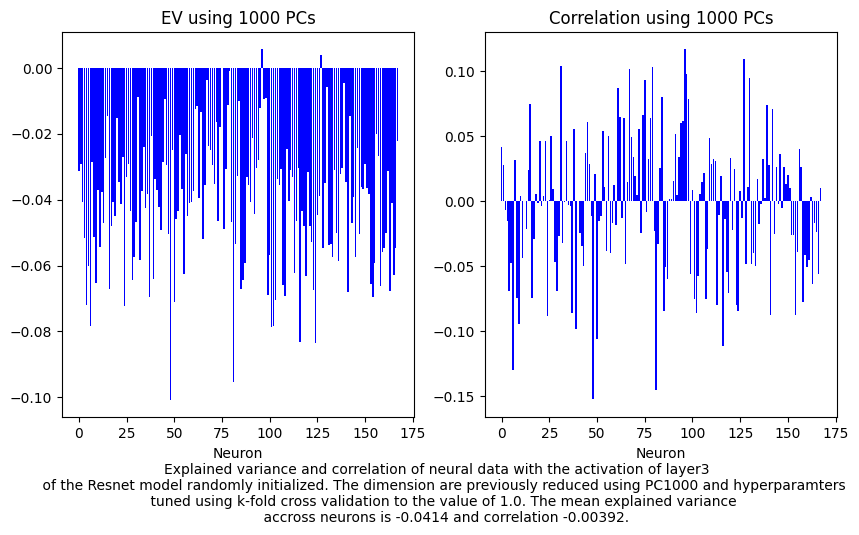

In [60]:
# Plot the layer 3 along neurons

fig, axs = plt.subplots(1, 2, figsize = (10, 5))

axs[0].bar(range(spikes_val.shape[1]), explained_variance_scores, color='blue')
axs[0].set_xlabel('Neuron')
axs[0].set_title('EV using 1000 PCs')

axs[1].bar(range(spikes_val.shape[1]), correlation_scores, color='blue')
axs[1].set_xlabel('Neuron')
axs[1].set_title('Correlation using 1000 PCs')
    
path_to_save = f'Fig/ev_{model_name}_{layer_name}_rnd'
    
txt = f'''Explained variance and correlation of neural data with the activation of layer3
    of the Resnet model randomly initialized. The dimension are previously reduced using PC1000 and hyperparamters 
    tuned using k-fold cross validation to the value of {best_alpha:.3}. The mean explained variance 
    accross neurons is {ev_mean:.3} and correlation {corr_mean:.3}.'''
    
fig.text(.5, -0.1, txt, ha='center')
    
fig.savefig(path_to_save)

Q: Which network can better predict the neural activity and why?